# Convolutional Neural Network (CNN)
This notebook aims to apply the CNN model to perform text classification and detect suicidal text.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, f1_score, precision_score
from sklearn.utils.class_weight import compute_class_weight

from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

from prettytable import PrettyTable

In [ ]:
# Specify GPU
device = torch.device("cuda")

In [ ]:
# Change to your own directory
try: 
    os.chdir("/content/drive/MyDrive/Suicide Project")
    print("Directory changed")
except OSError:
    print("Error: Can't change the Current Working Directory")

Directory changed


## Define constants

In [ ]:
# Define constants
EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 1e-5
SEED = 4222

## Load dataset

In [ ]:
# Load dataset
suicide_detection_df = pd.read_csv('Data/suicide_detection_final_cleaned.csv', header=0)
suicide_detection_df.drop(columns=['text'], axis=1, inplace=True)
suicide_detection_df = suicide_detection_df.rename(columns={"cleaned_text": "text"})
classes = {"suicide": 1, "non-suicide": 0}
suicide_detection_df = suicide_detection_df.replace({"class": classes})
suicide_detection_df.head()

,class,text
0,1,sex wife threaten suicide recently leave wife ...
1,0,weird not affect compliment come know girl fee...
2,0,finally hear bad year swear fuck god annoying
3,1,need help help cry hard
4,1,end tonight not anymore quit


## Train-Test-Val Split

In [ ]:
# Split dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(suicide_detection_df['text'], suicide_detection_df['class'],
                                                                    random_state=SEED,
                                                                    test_size=0.2,
                                                                    stratify=suicide_detection_df['class'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=SEED,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

## Max Length and Number of vocab words in Train set

In [ ]:
max_length = max([len(s.split()) for s in train_text])
max_length

62

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)

vocab_size = len(tokenizer.word_index) + 1

## Padding

In [ ]:
def tokenize_and_encode(text, max_length=62):
    """Tokenize and encode sequences."""

    # sequence encode
    encoded_docs = tokenizer.texts_to_sequences(text)
    # pad sequences
    padded_sequence = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

    return padded_sequence

# Tokenize and encode sequences in all datasets
tokens_train = tokenize_and_encode(train_text)
tokens_val = tokenize_and_encode(val_text)
tokens_test = tokenize_and_encode(test_text)

In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(tokens_train), torch.from_numpy(train_labels.to_numpy()))
val_data = TensorDataset(torch.from_numpy(tokens_val), torch.from_numpy(val_labels.to_numpy()))

# Sampler for sampling the data
train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)

# DataLoader
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

## Load Word Embedding

In [ ]:
# load embedding as a dict
def load_embedding(filename):
	# load embedding into memory, skip first line
	file = open(filename,'r')
	lines = file.readlines()[1:]
	file.close()
	# create a map of words to vectors
	embedding = dict()
	for line in lines:
		parts = line.split()
		# key is string word, value is numpy array for vector
		embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
	return embedding

In [ ]:
# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab, embedding_dim):
	# total vocabulary size plus 0 for unknown words
	vocab_size = len(vocab) + 1
	# define weight matrix dimensions with all 0
	weight_matrix = np.zeros((vocab_size, embedding_dim))
	# step vocab, store vectors using the Tokenizer's integer mapping
	for word, i in vocab.items():
		weight_matrix[i] = embedding.get(word)

	return weight_matrix

In [ ]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
    # emb_layer.weight.data.copy_(torch.from_numpy(weights_matrix))
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [ ]:
# load word2vec embedding from file
raw_embedding_word2vec = load_embedding('Data/embedding_word2vec.txt')
# get vectors in the right order
embedding_vectors_word2vec = get_weight_matrix(raw_embedding_word2vec, tokenizer.word_index, 300)
embedding_vectors_word2vec = np.float32(embedding_vectors_word2vec)

In [ ]:
# load glove embedding from file
raw_embedding_glove = load_embedding('Data/glove_twitter_27B_200d.txt')

In [ ]:
# get vectors in the right order
embedding_vectors_glove = get_weight_matrix(raw_embedding_glove, tokenizer.word_index, 200)
embedding_vectors_glove = np.float32(embedding_vectors_glove)

In [ ]:
for arr in embedding_vectors_glove:
    for idx, i in enumerate(arr):
        if np.isnan(arr[idx]):
            arr[idx] = 0

## CNN Model Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, 
                 n_filters, filter_sizes, output_dim,
                 dropout_rate, pre_trained=False, embedding_vectors=None):
        
        super().__init__()
        
        if pre_trained:
            self.embedding, num_embeddings, embedding_dim = create_emb_layer(embedding_vectors, True)
        else:
            # Create word embeddings from the input words
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Note: ModuleList holds a list of PyTorch nn.Modules.
        # Allowing us to pass in n number of filter sizes, thereby creating a convolutional layer for each of them
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, text): 
        '''
        Iterates through the filter size applied to each convolutional layer to get convolutional output,
        then apply max pooling before concatenating together and passing through the dropout and fully connected layers.

        text: contains [batch size, length of sentence]
        '''
        embedded = self.embedding(text) # [batch size, length of sentence, embedding dimension]
        
        embedded = embedded.permute(0, 2, 1) # rearrange to get [batch size, embedding dimension, length of  sentence]
    
        conved = [F.relu(conv(embedded)) for conv in self.convs] # [batch size, n_filters, length of sentence - filter_size of convu layer + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved] # [batch size, n_filters] for each convu layer
        
        cat = self.dropout(torch.cat(pooled, dim = 1)) # [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# Instantiate the model w/ hyperparams
embedding_dim = 300
n_filters = 32
filter_sizes = [5,6,7,8]
output_dim = 1
dropout_rate = 0.2

In [ ]:
# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# push to GPU
criterion = criterion.to(device)

### Model 1: No pre trained embedding weights

In [ ]:
model1 = CNN(vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout_rate, pre_trained=False)

print("No pre trained embedding weights")
print(model1)
print(f'Model 1 has {count_parameters(model1):,} trainable parameters')

No pre trained embedding weights
CNN(
  (embedding): Embedding(27605, 300)
  (convs): ModuleList(
    (0): Conv1d(300, 32, kernel_size=(5,), stride=(1,))
    (1): Conv1d(300, 32, kernel_size=(6,), stride=(1,))
    (2): Conv1d(300, 32, kernel_size=(7,), stride=(1,))
    (3): Conv1d(300, 32, kernel_size=(8,), stride=(1,))
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Model 1 has 8,531,357 trainable parameters


### Model 2: Word2Vec pre trained embedding weights

In [ ]:
model2 = CNN(vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout_rate, 
             pre_trained=True, embedding_vectors=embedding_vectors_word2vec)
model2.embedding.weight.data.copy_(torch.from_numpy(embedding_vectors_word2vec))

print("With Word2Vec pre trained embedding weights")
print(model2)
print(f'Model 2 has {count_parameters(model2):,} trainable parameters')

With Word2Vec pre trained embedding weights
CNN(
  (embedding): Embedding(27605, 300)
  (convs): ModuleList(
    (0): Conv1d(300, 32, kernel_size=(5,), stride=(1,))
    (1): Conv1d(300, 32, kernel_size=(6,), stride=(1,))
    (2): Conv1d(300, 32, kernel_size=(7,), stride=(1,))
    (3): Conv1d(300, 32, kernel_size=(8,), stride=(1,))
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Model 2 has 249,857 trainable parameters


### Model 3: gloVe Twitter dataset (200d) pre trained embedding weights

In [ ]:
model3 = CNN(vocab_size, 200, n_filters, filter_sizes, output_dim, dropout_rate, 
             pre_trained=True, embedding_vectors=embedding_vectors_glove)
model3.embedding.weight.data.copy_(torch.from_numpy(embedding_vectors_glove))

print("With gloVe pre trained embedding weights")
print(model3)
print(f'Model 3 has {count_parameters(model3):,} trainable parameters')

With gloVe pre trained embedding weights
CNN(
  (embedding): Embedding(27605, 200)
  (convs): ModuleList(
    (0): Conv1d(200, 32, kernel_size=(5,), stride=(1,))
    (1): Conv1d(200, 32, kernel_size=(6,), stride=(1,))
    (2): Conv1d(200, 32, kernel_size=(7,), stride=(1,))
    (3): Conv1d(200, 32, kernel_size=(8,), stride=(1,))
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Model 3 has 166,657 trainable parameters


## Helper functions to train and evaluate model

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [ ]:
# function to train the model
def train():

    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches of train data
    for step, batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('Batch {:>5,} of {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        # batch = [r.to(device) for r in batch]

        inputs, labels = batch
        inputs = inputs.type(torch.LongTensor)

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for current batch
        preds = model(inputs).squeeze(1)

        # compute the loss between actual and predicted values
        loss = criterion(preds.squeeze(), labels.float())

        # add on to the total loss
        total_loss += loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # compute accuracy
        acc = binary_accuracy(preds, labels)
        
        # add on to the total accuracy
        total_accuracy += acc.item()

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # compute the training acc of the epoch
    avg_acc = total_accuracy / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss, accuracy and predictions
    return avg_loss, avg_acc, total_preds

In [ ]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers

    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('Batch {:>5,} of {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        # batch = [t.to(device) for t in batch]

        inputs, labels = batch
        inputs = inputs.type(torch.LongTensor)

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(inputs).squeeze(1)

            # compute the validation loss between actual and predicted values
            loss = criterion(preds.squeeze(), labels.float())

            total_loss += loss.item()

            acc = binary_accuracy(preds, labels)

            total_accuracy += acc.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # compute the validation acc of the epoch
    avg_acc = total_accuracy / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, avg_acc, total_preds

## Model 1: No pre trained embedding weights

In [ ]:
!nvidia -smi

/bin/bash: nvidia: command not found


In [ ]:
# define the optimizer
optimizer = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

# push to GPU
model = model1.to(device)

MODEL_WEIGHTS_PATH = 'Models/cnn_model_1_saved_weights.pt'

### Train and Evaluate Model 1

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
model1_train_losses = []
model1_valid_losses = []

# empty lists to store training and validation acc of each epoch
model1_train_accuracies = []
model1_valid_accuracies = []

train_on_gpu = True

# for each epoch
for epoch in range(EPOCHS):

    print('\n Epoch {:} / {:}'.format(epoch+1, EPOCHS))
    
    # train model
    train_loss, train_acc, _ = train()

    # evaluate model
    valid_loss, valid_acc, _ = evaluate()

    # save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
    
    # append training and validation loss
    model1_train_losses.append(train_loss)
    model1_valid_losses.append(valid_loss)

    # append training and validation acc
    model1_train_accuracies.append(train_acc)
    model1_valid_accuracies.append(valid_acc)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    print(f'\nTraining Accuracy: {train_acc:.3f}')
    print(f'Validation Accuracy: {valid_acc:.3f}')


 Epoch 1 / 5
Batch    50 of 4,396.
Batch   100 of 4,396.
Batch   150 of 4,396.
Batch   200 of 4,396.
Batch   250 of 4,396.
Batch   300 of 4,396.
Batch   350 of 4,396.
Batch   400 of 4,396.
Batch   450 of 4,396.
Batch   500 of 4,396.
Batch   550 of 4,396.
Batch   600 of 4,396.
Batch   650 of 4,396.
Batch   700 of 4,396.
Batch   750 of 4,396.
Batch   800 of 4,396.
Batch   850 of 4,396.
Batch   900 of 4,396.
Batch   950 of 4,396.
Batch 1,000 of 4,396.
Batch 1,050 of 4,396.
Batch 1,100 of 4,396.
Batch 1,150 of 4,396.
Batch 1,200 of 4,396.
Batch 1,250 of 4,396.
Batch 1,300 of 4,396.
Batch 1,350 of 4,396.
Batch 1,400 of 4,396.
Batch 1,450 of 4,396.
Batch 1,500 of 4,396.
Batch 1,550 of 4,396.
Batch 1,600 of 4,396.
Batch 1,650 of 4,396.
Batch 1,700 of 4,396.
Batch 1,750 of 4,396.
Batch 1,800 of 4,396.
Batch 1,850 of 4,396.
Batch 1,900 of 4,396.
Batch 1,950 of 4,396.
Batch 2,000 of 4,396.
Batch 2,050 of 4,396.
Batch 2,100 of 4,396.
Batch 2,150 of 4,396.
Batch 2,200 of 4,396.
Batch 2,250 of 4,3

In [ ]:
# load weights of best model cnn
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

### Run trained model 1 on Test dataset

In [ ]:
# create Tensor datasets
test_data = TensorDataset(torch.from_numpy(tokens_test), torch.from_numpy(test_labels.to_numpy()))

# Sampler for sampling the data
test_sampler = SequentialSampler(test_data)

# DataLoader
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
# empty list to save the model predictions
total_preds = []

# iterate over batches
for step, batch in enumerate(test_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
        print('Batch {:>5,} of {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    # batch = [t.to(device) for t in batch]

    inputs, labels = batch
    inputs = inputs.type(torch.LongTensor)

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    # deactivate autograd
    with torch.no_grad():

        # model predictions
        preds = model(inputs).squeeze(1)

        # convert output probabilities to predicted class (0 or 1)
        preds = torch.round(torch.sigmoid(preds.squeeze()))  # rounds to the nearest integer

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

# reshape the predictions in form of (number of samples, no. of classes)
total_preds = np.concatenate(total_preds, axis=0)

Batch    50 of   550.
Batch   100 of   550.
Batch   150 of   550.
Batch   200 of   550.
Batch   250 of   550.
Batch   300 of   550.
Batch   350 of   550.
Batch   400 of   550.
Batch   450 of   550.
Batch   500 of   550.


### Model 1 Summary

In [ ]:
print(classification_report(test_labels, total_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9067    0.9394    0.9228     10744
           1     0.8991    0.8482    0.8729      6839

    accuracy                         0.9039     17583
   macro avg     0.9029    0.8938    0.8979     17583
weighted avg     0.9038    0.9039    0.9034     17583



In [ ]:
model_1_test_accuracy_score = accuracy_score(test_labels, total_preds)
model_1_test_precision_score = precision_score(test_labels, total_preds)
model_1_test_recall_score = recall_score(test_labels, total_preds)
model_1_test_f1_score = f1_score(test_labels, total_preds)

## Model 2: Word2Vec pre trained embedding weights

In [ ]:
# define the optimizer
optimizer = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

# push to GPU
model = model2.to(device)

MODEL_WEIGHTS_PATH = 'Models/cnn_model_2_saved_weights.pt'

### Train and Evaluate Model 2

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
model2_train_losses = []
model2_valid_losses = []

# empty lists to store training and validation acc of each epoch
model2_train_accuracies = []
model2_valid_accuracies = []

train_on_gpu = True

# for each epoch
for epoch in range(EPOCHS):

    print('\n Epoch {:} / {:}'.format(epoch+1, EPOCHS))
    
    # train model
    train_loss, train_acc, _ = train()

    # evaluate model
    valid_loss, valid_acc, _ = evaluate()

    # save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
    
    # append training and validation loss
    model2_train_losses.append(train_loss)
    model2_valid_losses.append(valid_loss)

    # append training and validation acc
    model2_train_accuracies.append(train_acc)
    model2_valid_accuracies.append(valid_acc)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    print(f'\nTraining Accuracy: {train_acc:.3f}')
    print(f'Validation Accuracy: {valid_acc:.3f}')


 Epoch 1 / 5
Batch    50 of 4,396.
Batch   100 of 4,396.
Batch   150 of 4,396.
Batch   200 of 4,396.
Batch   250 of 4,396.
Batch   300 of 4,396.
Batch   350 of 4,396.
Batch   400 of 4,396.
Batch   450 of 4,396.
Batch   500 of 4,396.
Batch   550 of 4,396.
Batch   600 of 4,396.
Batch   650 of 4,396.
Batch   700 of 4,396.
Batch   750 of 4,396.
Batch   800 of 4,396.
Batch   850 of 4,396.
Batch   900 of 4,396.
Batch   950 of 4,396.
Batch 1,000 of 4,396.
Batch 1,050 of 4,396.
Batch 1,100 of 4,396.
Batch 1,150 of 4,396.
Batch 1,200 of 4,396.
Batch 1,250 of 4,396.
Batch 1,300 of 4,396.
Batch 1,350 of 4,396.
Batch 1,400 of 4,396.
Batch 1,450 of 4,396.
Batch 1,500 of 4,396.
Batch 1,550 of 4,396.
Batch 1,600 of 4,396.
Batch 1,650 of 4,396.
Batch 1,700 of 4,396.
Batch 1,750 of 4,396.
Batch 1,800 of 4,396.
Batch 1,850 of 4,396.
Batch 1,900 of 4,396.
Batch 1,950 of 4,396.
Batch 2,000 of 4,396.
Batch 2,050 of 4,396.
Batch 2,100 of 4,396.
Batch 2,150 of 4,396.
Batch 2,200 of 4,396.
Batch 2,250 of 4,3

In [ ]:
# load weights of best model cnn
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

### Run trained model 2 on Test dataset

In [ ]:
# create Tensor datasets
test_data = TensorDataset(torch.from_numpy(tokens_test), torch.from_numpy(test_labels.to_numpy()))

# Sampler for sampling the data
test_sampler = SequentialSampler(test_data)

# DataLoader
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
# empty list to save the model predictions
total_preds = []

# iterate over batches
for step, batch in enumerate(test_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
        print('Batch {:>5,} of {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    # batch = [t.to(device) for t in batch]

    inputs, labels = batch
    inputs = inputs.type(torch.LongTensor)

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    # deactivate autograd
    with torch.no_grad():

        # model predictions
        preds = model(inputs).squeeze(1)

        # convert output probabilities to predicted class (0 or 1)
        preds = torch.round(torch.sigmoid(preds.squeeze()))  # rounds to the nearest integer

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

# reshape the predictions in form of (number of samples, no. of classes)
total_preds = np.concatenate(total_preds, axis=0)

Batch    50 of   550.
Batch   100 of   550.
Batch   150 of   550.
Batch   200 of   550.
Batch   250 of   550.
Batch   300 of   550.
Batch   350 of   550.
Batch   400 of   550.
Batch   450 of   550.
Batch   500 of   550.


### Model 2 Summary

In [ ]:
print(classification_report(test_labels, total_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9319    0.9338    0.9329     10744
           1     0.8957    0.8928    0.8943      6839

    accuracy                         0.9179     17583
   macro avg     0.9138    0.9133    0.9136     17583
weighted avg     0.9178    0.9179    0.9179     17583



In [ ]:
model_2_test_accuracy_score = accuracy_score(test_labels, total_preds)
model_2_test_precision_score = precision_score(test_labels, total_preds)
model_2_test_recall_score = recall_score(test_labels, total_preds)
model_2_test_f1_score = f1_score(test_labels, total_preds)

## Model 3: gloVe Twitter dataset (200d) pre trained embedding weights

In [ ]:
# define the optimizer
optimizer = optim.Adam(model3.parameters(), lr=LEARNING_RATE)

# push to GPU
model = model3.to(device)

MODEL_WEIGHTS_PATH = 'Models/cnn_model_3_saved_weights.pt'

### Train and Evaluate Model 3

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
model3_train_losses = []
model3_valid_losses = []

# empty lists to store training and validation acc of each epoch
model3_train_accuracies = []
model3_valid_accuracies = []

train_on_gpu = True

# for each epoch
for epoch in range(EPOCHS):

    print('\n Epoch {:} / {:}'.format(epoch+1, EPOCHS))
    
    # train model
    train_loss, train_acc, _ = train()

    # evaluate model
    valid_loss, valid_acc, _ = evaluate()

    # save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
    
    # append training and validation loss
    model3_train_losses.append(train_loss)
    model3_valid_losses.append(valid_loss)

    # append training and validation acc
    model3_train_accuracies.append(train_acc)
    model3_valid_accuracies.append(valid_acc)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    print(f'\nTraining Accuracy: {train_acc:.3f}')
    print(f'Validation Accuracy: {valid_acc:.3f}')


 Epoch 1 / 5
Batch    50 of 4,396.
Batch   100 of 4,396.
Batch   150 of 4,396.
Batch   200 of 4,396.
Batch   250 of 4,396.
Batch   300 of 4,396.
Batch   350 of 4,396.
Batch   400 of 4,396.
Batch   450 of 4,396.
Batch   500 of 4,396.
Batch   550 of 4,396.
Batch   600 of 4,396.
Batch   650 of 4,396.
Batch   700 of 4,396.
Batch   750 of 4,396.
Batch   800 of 4,396.
Batch   850 of 4,396.
Batch   900 of 4,396.
Batch   950 of 4,396.
Batch 1,000 of 4,396.
Batch 1,050 of 4,396.
Batch 1,100 of 4,396.
Batch 1,150 of 4,396.
Batch 1,200 of 4,396.
Batch 1,250 of 4,396.
Batch 1,300 of 4,396.
Batch 1,350 of 4,396.
Batch 1,400 of 4,396.
Batch 1,450 of 4,396.
Batch 1,500 of 4,396.
Batch 1,550 of 4,396.
Batch 1,600 of 4,396.
Batch 1,650 of 4,396.
Batch 1,700 of 4,396.
Batch 1,750 of 4,396.
Batch 1,800 of 4,396.
Batch 1,850 of 4,396.
Batch 1,900 of 4,396.
Batch 1,950 of 4,396.
Batch 2,000 of 4,396.
Batch 2,050 of 4,396.
Batch 2,100 of 4,396.
Batch 2,150 of 4,396.
Batch 2,200 of 4,396.
Batch 2,250 of 4,3

In [ ]:
# load weights of best model cnn
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

### Run trained model 3 on Test dataset

In [ ]:
# create Tensor datasets
test_data = TensorDataset(torch.from_numpy(tokens_test), torch.from_numpy(test_labels.to_numpy()))

# Sampler for sampling the data
test_sampler = SequentialSampler(test_data)

# DataLoader
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
# empty list to save the model predictions
total_preds = []

# iterate over batches
for step, batch in enumerate(test_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
        print('Batch {:>5,} of {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    # batch = [t.to(device) for t in batch]

    inputs, labels = batch
    inputs = inputs.type(torch.LongTensor)

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    # deactivate autograd
    with torch.no_grad():

        # model predictions
        preds = model(inputs).squeeze(1)

        # convert output probabilities to predicted class (0 or 1)
        preds = torch.round(torch.sigmoid(preds.squeeze()))  # rounds to the nearest integer

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

# reshape the predictions in form of (number of samples, no. of classes)
total_preds = np.concatenate(total_preds, axis=0)

Batch    50 of   550.
Batch   100 of   550.
Batch   150 of   550.
Batch   200 of   550.
Batch   250 of   550.
Batch   300 of   550.
Batch   350 of   550.
Batch   400 of   550.
Batch   450 of   550.
Batch   500 of   550.


### Model 3 Summary

In [ ]:
print(classification_report(test_labels, total_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9085    0.9205    0.9145     10744
           1     0.8725    0.8544    0.8633      6839

    accuracy                         0.8948     17583
   macro avg     0.8905    0.8874    0.8889     17583
weighted avg     0.8945    0.8948    0.8946     17583



In [ ]:
model_3_test_accuracy_score = accuracy_score(test_labels, total_preds)
model_3_test_precision_score = precision_score(test_labels, total_preds)
model_3_test_recall_score = recall_score(test_labels, total_preds)
model_3_test_f1_score = f1_score(test_labels, total_preds)

## Comparison across 3 models

In [ ]:
table = PrettyTable()
table.field_names = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

table.add_row(['CNN without pre trained embedding weights', 
               format(model_1_test_accuracy_score, '.4f'), 
               format(model_1_test_precision_score, '.4f'), 
               format(model_1_test_recall_score, '.4f'), 
               format(model_1_test_f1_score, '.4f')])

table.add_row(['CNN with Word2Vec pre trained embedding weights', 
               format(model_2_test_accuracy_score, '.4f'), 
               format(model_2_test_precision_score, '.4f'), 
               format(model_2_test_recall_score, '.4f'), 
               format(model_2_test_f1_score, '.4f')])

table.add_row(['CNN with gloVe Twitter (200d) pre trained embedding weights', 
               format(model_3_test_accuracy_score, '.4f'), 
               format(model_3_test_precision_score, '.4f'), 
               format(model_3_test_recall_score, '.4f'), 
               format(model_3_test_f1_score, '.4f')])
print(table)

+-------------------------------------------------------------+----------+-----------+--------+----------+
|                            Model                            | Accuracy | Precision | Recall | F1 Score |
+-------------------------------------------------------------+----------+-----------+--------+----------+
|          CNN without pre trained embedding weights          |  0.9039  |   0.8991  | 0.8482 |  0.8729  |
|       CNN with Word2Vec pre trained embedding weights       |  0.9179  |   0.8957  | 0.8928 |  0.8943  |
| CNN with gloVe Twitter (200d) pre trained embedding weights |  0.8948  |   0.8725  | 0.8544 |  0.8633  |
+-------------------------------------------------------------+----------+-----------+--------+----------+


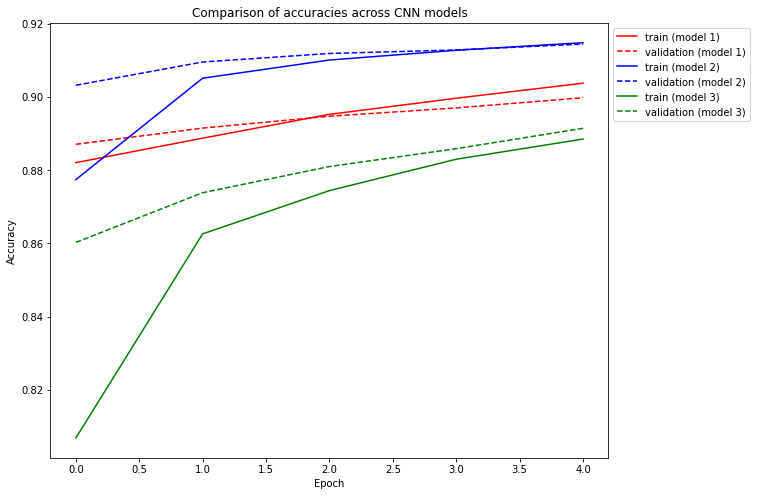

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(10,8))
plt.plot(model1_train_accuracies, "r-")
plt.plot(model1_valid_accuracies, "r--")
plt.plot(model2_train_accuracies, "b-")
plt.plot(model2_valid_accuracies, "b--")
plt.plot(model3_train_accuracies, "g-")
plt.plot(model3_valid_accuracies, "g--")
plt.title('Comparison of accuracies across CNN models')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train (model 1)', 'validation (model 1)', 'train (model 2)', 'validation (model 2)', 'train (model 3)', 'validation (model 3)'], 
           bbox_to_anchor=(1, 1))
           #loc='upper left')
plt.show()